In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
file_global = 'spotifycharts_20170629to20180126_global.csv'

df = pd.read_csv(file_global)
# add column of log-transformed streams
df['log_streams'] = np.log(df['Streams'])
# add top 50 indicator variable
df['top_50'] = (df['Position'] <= 50).astype(int)
df

,region,date,Position,Track Name,Artist,Streams,URL,log_streams,top_50
0,global,2017-06-29,1,Despacito - Remix,Luis Fonsi,5945441,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,15.598135,1
1,global,2017-06-29,2,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,4496288,https://open.spotify.com/track/1OAh8uOEOvTDqkK...,15.318763,1
2,global,2017-06-29,3,"I'm the One (feat. Justin Bieber, Quavo, Chanc...",DJ Khaled,4291359,https://open.spotify.com/track/3DXncPQOG4VBw3Q...,15.272114,1
3,global,2017-06-29,4,2U (feat. Justin Bieber),David Guetta,3849460,https://open.spotify.com/track/3A7qX2QjDlPnazU...,15.163443,1
4,global,2017-06-29,5,Shape of You,Ed Sheeran,3492692,https://open.spotify.com/track/7qiZfU4dY1lWllz...,15.066183,1
...,...,...,...,...,...,...,...,...,...
42377,global,2018-01-26,196,Redbone,Childish Gambino,623117,https://open.spotify.com/track/3kxfsdsCpFgN412...,13.342490,0
42378,global,2018-01-26,197,The Weekend - Funk Wav Remix,SZA,614714,https://open.spotify.com/track/0P6AWOA4LG1XOct...,13.328912,0
42379,global,2018-01-26,198,Stay,Zedd,612468,https://open.spotify.com/track/0I20rLT2MJDhcF9...,13.325252,0
42380,global,2018-01-26,199,From Now On,Hugh Jackman,610407,https://open.spotify.com/track/3IkWmgGsXbsafru...,13.321881,0


(a)

In [3]:
# regression of streams on top 50 inclusion
X = df['top_50']
y = df['log_streams']
X = sm.add_constant(X)
lr = sm.OLS(y, X)
results = lr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_streams   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                 1.026e+05
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:42:10   Log-Likelihood:                -8150.0
No. Observations:               42382   AIC:                         1.630e+04
Df Residuals:                   42380   BIC:                         1.632e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4247      0.002   8162.163      0.0

(b)

Supplmementing the data with controls:

In [4]:
# total daily streams of top 50 (were more people listening to popular music on that day?)
df_50 = df[df['Position'] <= 50]
df_tot_50 = df_50[['date', 'Streams']].groupby('date').sum().reset_index().rename(columns={'Streams': 'top_50_streams'})
df = pd.merge(df, df_tot_50, how='left', on='date')

# total daily streams of top 200 (were more people listening to music on that day?)
# note that more than the top 200 would have been helpful here
df_tot_200 = df[['date', 'Streams']].groupby('date').sum().reset_index().rename(columns={'Streams':'top_200_streams'})
df = pd.merge(df, df_tot_200, how='left', on='date')

# these 2 dummies account more for differences in individual days as opposed to days of the week
# could also add top_10_streams, top_5_streams, etc.

# add feature indicator
df['feature'] = (df['Track Name'].apply(lambda x: 'feat' in x.lower())).astype(int)
# add remix indicator
df['remix'] = df['Track Name'].apply(lambda x: 'remix' in x.lower()).astype(int)

# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# add day fixed effects
df['Day of Week'] = df['date'].dt.day_name() # get day of week
df = pd.get_dummies(df, columns=['Day of Week'], prefix='d')
df = df.drop(columns=['d_Sunday']) # drop Sunday since generally has the least streams

# add month fixed effects
df['Month'] = df['date'].dt.month_name() # get day of week
df = pd.get_dummies(df, columns=['Month'], prefix='m')
df = df.drop(columns=['m_July']) # didn't want to drop June since we only have the 29th and 30th

# add holiday dummy
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
# 2017-10-09 and 2018-01-15 are not holidays; 2017-10-31 is
holidays = list(holidays) # convert to list for mutability
holidays.remove(pd.to_datetime('2017-10-09', format='%Y-%m-%d'))
holidays.remove(pd.to_datetime('2018-01-15', format='%Y-%m-%d'))
holidays.append(pd.to_datetime('2017-10-31', format='%Y-%m-%d'))
df['holiday'] = df['date'].isin(holidays).astype(int)

Assessing need for transformations and applying them if necessary:

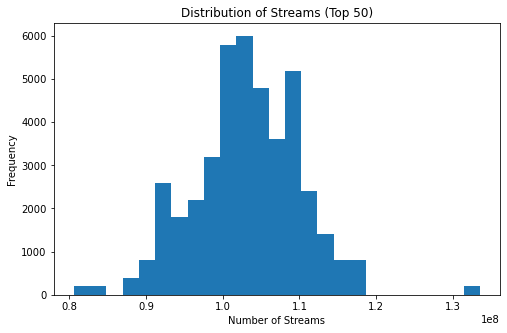

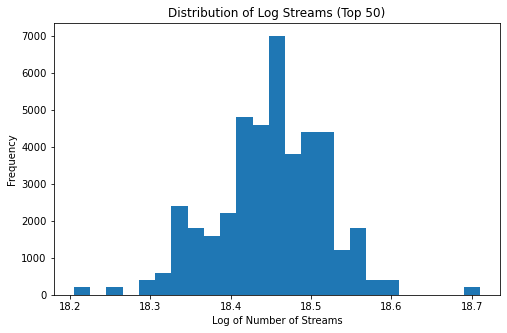

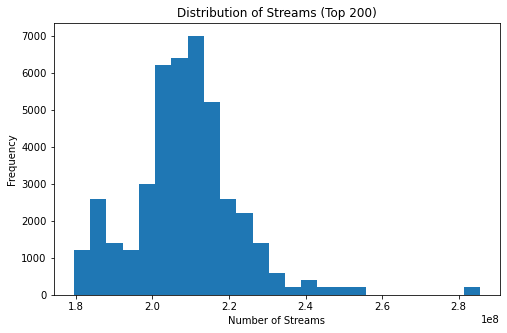

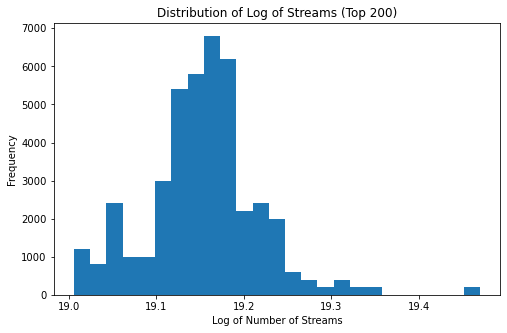

In [5]:
plt.figure(figsize=(8,5))
plt.hist(df['top_50_streams'], bins=25)
plt.title('Distribution of Streams (Top 50)')
plt.xlabel('Number of Streams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(np.log(df['top_50_streams']), bins=25)
plt.title('Distribution of Log Streams (Top 50)')
plt.xlabel('Log of Number of Streams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['top_200_streams'], bins=25)
plt.title('Distribution of Streams (Top 200)')
plt.xlabel('Number of Streams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(np.log(df['top_200_streams']), bins=25)
plt.title('Distribution of Log of Streams (Top 200)')
plt.xlabel('Log of Number of Streams')
plt.ylabel('Frequency')
plt.show()

In [6]:
# log transforming top streams (use these since since still ~normally distributed and help interpretability)
df['log_top_50_streams'] = np.log(df['top_50_streams'])
df['log_top_200_streams'] = np.log(df['top_200_streams'])

In [7]:
# regression of streams on top 50 inclusion with controls
day_fe = [col for col in df.columns if col.startswith('d_')]
month_fe = [col for col in df.columns if col.startswith('m_')]
X = df[['top_50', 'log_top_50_streams', 'log_top_200_streams', 'feature', 'remix', 'holiday'] + day_fe + month_fe]
X = sm.add_constant(X)
y = df['log_streams']
lr = sm.OLS(y, X)
results = lr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_streams   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     5988.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:42:11   Log-Likelihood:                -6565.1
No. Observations:               42382   AIC:                         1.317e+04
Df Residuals:                   42362   BIC:                         1.334e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.9953    

Not that this is NOT the optimal approach for determining the effect on streams of inclusion in the top 50--see part 4.